In [1]:
import os
import io

import cv2 as cv
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from PIL import Image as pil_image
from IPython.html import widgets

from ipywidgets import interact, interact_manual
from IPython.display import display, Image, clear_output

/usr/local/lib/python3.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Utilities

In [80]:
def imgs_show(imgs, rows, fontsize=36):
    fig = plt.figure()
    for n, (img, title) in enumerate(imgs):
        a = fig.add_subplot(rows, np.ceil(len(imgs)/float(rows)), n + 1)
        a.set_title(title, fontdict={"fontsize": fontsize})
        plt.imshow(img)
    fig.set_size_inches(np.array(fig.get_size_inches()) * len(imgs))
    plt.show()

def read_folder(folder, ext):
    images = []
    for filename in sorted(os.listdir(folder)):
        if filename.endswith(ext):
            path = os.path.join(folder, filename)
            images.append(np.array(pil_image.open(path)))
    return images

def img_show(img, title = '', figsize=(10, 5)):
    plt.figure(figsize=figsize)
    plt.gray()
    plt.imshow(img)
    plt.title(title)
    plt.show()

def display_frames_sequence(frames):
    def exec(i):
        a = np.uint8(frames[i])
        f = io.StringIO()

        imgByteArr = io.BytesIO()
        pil_image.fromarray(a, 'RGB').save(imgByteArr, format='PNG')
        display(Image(data=imgByteArr.getvalue()))
        
    widgets.interact(exec, i=widgets.IntSlider(min=0, max=len(frames) - 1, step=1, value=0))
    
def read_frames_dataset(path, ext='.jpg'):
    frames = read_folder(os.path.join(path, 'img/'), ext)
    df = pd.read_csv(os.path.join(path, 'groundtruth_rect.txt'), names=['x', 'y', 'w', 'h'])
    return frames, df

def enreach_single_frame_with_tracking_ractangle(frame, track_window, color=(0, 255, 0)):
    x,y,w,h = track_window
    return cv.rectangle(np.copy(frame), (x,y), (x+w,y+h), color, 2)

def enreach_frames_with_tracking_ractangle(frames, tracking_df, color=(0, 255, 0)):
    enreached_frames = []
    for i, frame in enumerate(frames):
        row = tracking_df.iloc[i]
        enreached_frame = enreach_single_frame_with_tracking_ractangle(
            frame, 
            (row['x'], row['y'], row['w'], row['h']),
            color
        )
        enreached_frames.append(enreached_frame)
    return enreached_frames

# Load and configure data

In [6]:
names = {
    "transformer": './datasets/Transformer/',
    "bike": './datasets/MountainBike/', 
    "football": './datasets/Football1/', 
    "bolt": './datasets/Bolt/', 
    "panda": './datasets/Panda/'
}

In [81]:
transformer, transformer_df = read_frames_dataset(names[0])
mountain_bike, mountain_bike_df = read_frames_dataset(names[1])
football, football_df = read_frames_dataset(names[2])
bolt, bolt_df = read_frames_dataset(names[3])
panda, panda_df = read_frames_dataset(names[4])

# example
transformer_df.head()

,x,y,w,h
0,196,51,139,194
1,192,46,145,202
2,196,46,140,193
3,195,48,140,199
4,190,46,146,199


In [138]:
display_frames_sequence(enreach_frames_with_tracking_ractangle(mountain_bike, mountain_bike_df))

interactive(children=(IntSlider(value=0, description='i', max=227), Output()), _dom_classes=('widget-interact'…

# Mean shift

In [174]:
class MeanShift:
    
    # The termination criteria, either 10 iteration or move by atleast 1 pt
    TERMINATION_CRITERIA = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1)
    
    COLOR_RED = (255, 0, 0)
    COLOR_GREEN = (0, 255, 0)
    
    HIST_RANGE = [0, 180]
    HIST_SIZE = [180]
    
    SCALE = 1
    
    def __init__(self, init_frame, config):
        self.init_frame = init_frame
        self.config = config
    
    @staticmethod
    def normalize_frame(img):
        normalized_img = np.copy(img)
        s = np.sum(img, axis=2)
        for i in range(img.shape[2]):
            normalized_img[:, :, i] = np.divide(img[:, :, i], s) * 255
        return normalized_img
        
    def fit(self, normalize=False):
        x, y, w, h = self.config["track_window"]
        roi = self.init_frame[y:y + h, x:x + w]
        img_show(roi)
        
        if normalize:
            roi = MeanShift.normalize_frame(roi)
        
        new_roi = cv.cvtColor(roi, cv.COLOR_BGR2HSV)
        
        mask = cv.inRange(new_roi, np.array(self.config["ranges"]["min"]), np.array(self.config["ranges"]["max"]))
        
        imgs_show([
            (roi, "roi"),
            (new_roi, "hsv roi"),
            (new_roi[:,:,0], "hsv chan 0"), 
            (new_roi[:,:,1], "hsv chan 1"), 
            (new_roi[:,:,2], "hsv chan 2"),
            (mask, "mask")
        ], 1)
        
        hist = cv.calcHist([new_roi], self.config["channels"], mask, MeanShift.HIST_SIZE, MeanShift.HIST_RANGE)
        self.roi_hist = cv.normalize(hist, hist, 0, 255, cv.NORM_MINMAX)
    
    def predict(self, frame):
        hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
        res = cv.calcBackProject([hsv], self.config["channels"], self.roi_hist, MeanShift.HIST_RANGE, MeanShift.SCALE)
        # apply meanshift to get the new location
        return cv.meanShift(res, self.config["track_window"], MeanShift.TERMINATION_CRITERIA)
    
    @staticmethod
    def run(frames, df, config, with_ground_truth=False, normalize=False):
        # get initial roi
        track_window = config["track_window"]
        
        # create and fit MeanShift instance
        mean_shift = MeanShift(frames[0], config)
        mean_shift.fit(normalize=normalize)
        
        result = [enreach_single_frame_with_tracking_ractangle(frames[0], track_window, MeanShift.COLOR_RED)]
        
        # predict other frames
        for frame in frames[1:]:
            _, track_window = mean_shift.predict(frame)
            result.append(enreach_single_frame_with_tracking_ractangle(frame, track_window, MeanShift.COLOR_RED))
        
        # add gound truth plots to images
        if with_ground_truth:
            for i, frame in enumerate(result):
                row = df.iloc[i]
                result[i] = enreach_single_frame_with_tracking_ractangle(
                    frame, 
                    (row['x'], row['y'], row['w'], row['h']),
                    MeanShift.COLOR_GREEN
                )
                
        display_frames_sequence(result)
        
        return result

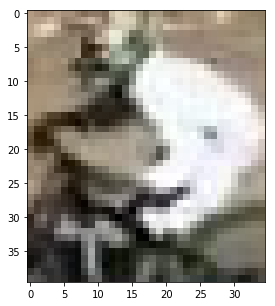

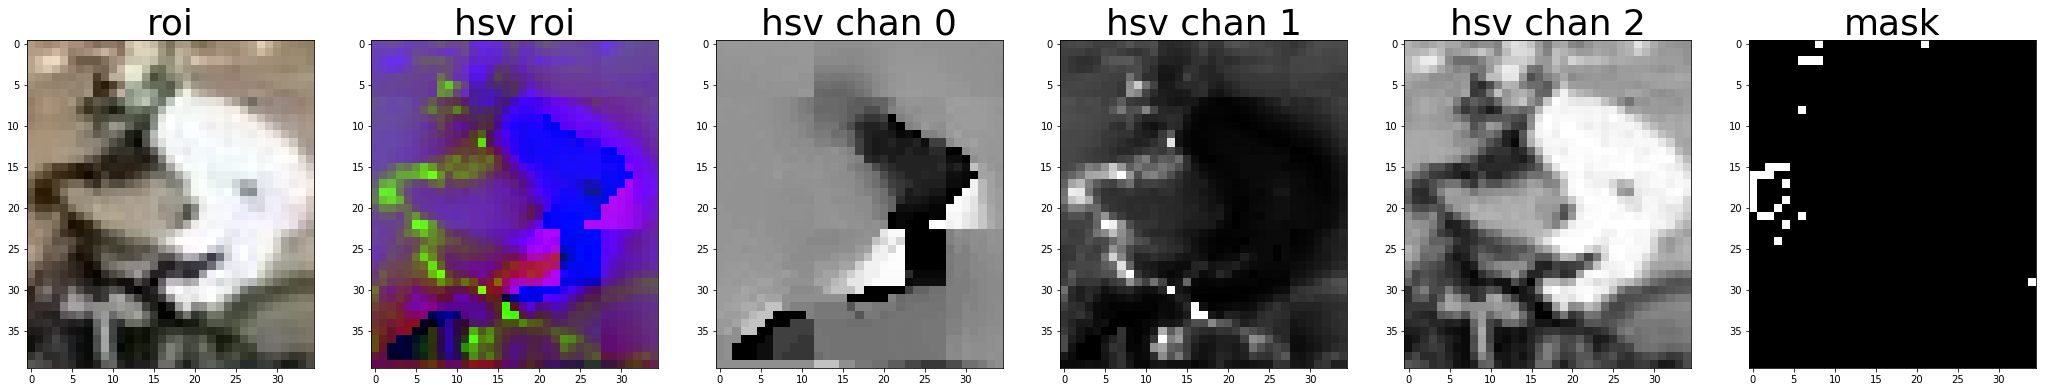

interactive(children=(IntSlider(value=0, description='i', max=227), Output()), _dom_classes=('widget-interact'…

In [182]:
config = {
        "track_window": (340, 185, 35, 40),
        "channels": [2],
        "ranges": {
            "min": (80., 80., 80.),
            "max": (140., 140., 140.)
        }
    }
result = MeanShift.run(mountain_bike, mountain_bike_df, config, with_ground_truth=True)

# Cam shift

In [8]:
class CamShift(MeanShift):
    @staticmethod
    def run(video, coords=[(0, 0), (0, 0)]):
        pass